shape of timeseries:(144, 1)
shape of X_train:torch.Size([92, 4, 1])
Epoch 0: train RMSE 226.0320, test RMSE 425.2695
Epoch 100: train RMSE 177.8363, test RMSE 374.7212
Epoch 200: train RMSE 141.1638, test RMSE 334.6021
Epoch 300: train RMSE 111.3408, test RMSE 299.1731
Epoch 400: train RMSE 89.4347, test RMSE 268.4925
Epoch 500: train RMSE 68.5352, test RMSE 237.1891
Epoch 600: train RMSE 53.7105, test RMSE 209.1713
Epoch 700: train RMSE 43.1741, test RMSE 184.9999
Epoch 800: train RMSE 35.9328, test RMSE 164.1251
Epoch 900: train RMSE 30.8845, test RMSE 145.9066
Epoch 1000: train RMSE 27.5218, test RMSE 131.1423
Epoch 1100: train RMSE 25.2101, test RMSE 119.1925
Epoch 1200: train RMSE 23.6620, test RMSE 109.5464
Epoch 1300: train RMSE 22.7058, test RMSE 101.5828
Epoch 1400: train RMSE 21.9989, test RMSE 95.7156
Epoch 1500: train RMSE 21.2124, test RMSE 89.9414
Epoch 1600: train RMSE 20.6905, test RMSE 86.1419
Epoch 1700: train RMSE 20.4244, test RMSE 82.4940
Epoch 1800: train RMSE 20

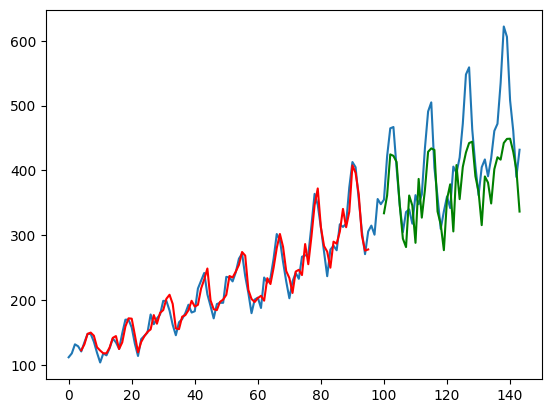

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

df = pd.read_csv('./datasets/airline-passengers.csv')
timeseries = df[["Passengers"]].values.astype('float32')

print("shape of timeseries:{}".format(timeseries.shape))

# train-test split for time series
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

lookback = 4
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print("shape of X_train:{}".format(X_train.shape))

class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries)
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()